In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json


# Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
###
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
####
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#####
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Creation of confusion matrix in using sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

## **Data Extraction and Preprocessing**

In [3]:
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

In [4]:
df_reviews.head()                                                                                                                                                                                                                                                                                                                            

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [5]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


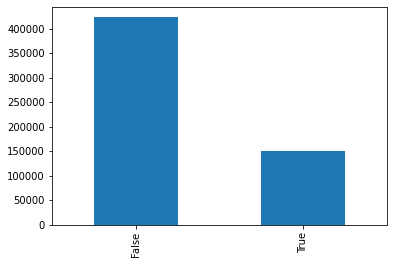

In [6]:
df_reviews["is_spoiler"].value_counts().plot(kind= "bar")
plt.show()

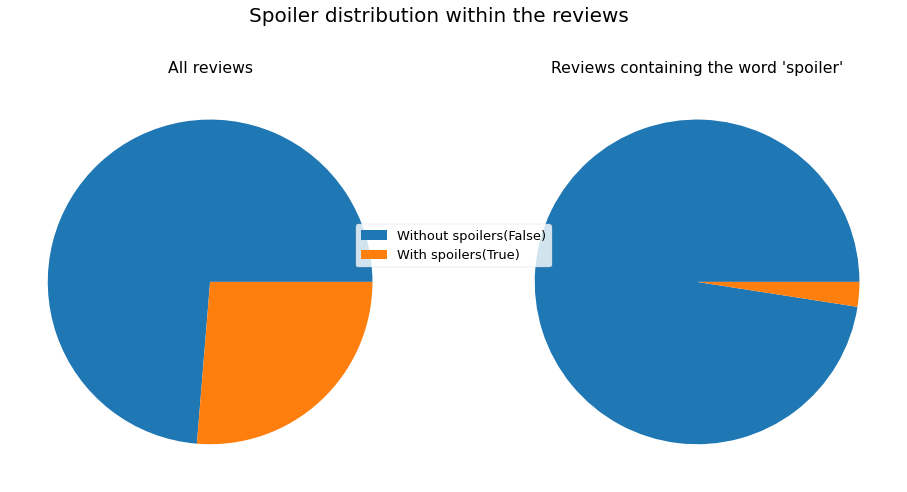

In [7]:
##### Extract the information from the data
spoiler_df = pd.DataFrame()
spoiler_df["is_spoiler"] = df_reviews["is_spoiler"] 
spoiler_df["has_a_word_spoiler"] = df_reviews["review_text"].apply(lambda 
                                                                  text : True if "spoiler" in text 
                                                                  else False)

pie1 = spoiler_df['is_spoiler'].value_counts().reset_index().sort_values(by='index')
pie2 = spoiler_df["has_a_word_spoiler"].value_counts().reset_index().sort_values(by='index')

with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.pie(pie1['is_spoiler'])
    ax1.set_title('All reviews')

    ax2.pie(pie2['has_a_word_spoiler'])
    ax2.set_title('Reviews containing the word \'spoiler\'')

    plt.suptitle('Spoiler distribution within the reviews', fontsize=20)
    fig.legend(labels=['Without spoilers(False)', 'With spoilers(True)'], loc='center')

    plt.show()

## **Picked a Small Batch of data to choose a best model for classification**

In [8]:
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

In [9]:
d = get_part_data(df_reviews, 10000)
d["is_spoiler"] = d["is_spoiler"].astype('int')

df_r = d[["review_text","is_spoiler"]]

In [10]:
d.head()

,movie_id,review_text,review_summary,is_spoiler
0,tt1049413,Overall: This movie is just simply excellent. ...,One of Pixar's Best; My personal favourite,1
1,tt1131734,I decided to watch Jennifer's Body after my fa...,One of the most enjoyable films I have ever w...,1
2,tt0451279,This review focuses on Greek Mythology in the ...,Serious Greek Myth Fail,1
3,tt1723811,I personally do not understand it when people ...,A shameful tragedy!,1
4,tt0464154,"I loved this film, was truly great fun, OK the...",Great Fun,1


## **Pre-process the reviews by removing the stop words, tokenizing and lemmitization**

In [11]:
import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [12]:
# lower the words in training data
ltexts = [[word.lower() for word in line.split()] for line in df_r["review_text"]]

In [13]:
def preprocess(text):
    text = ' '.join(text)
    # tokenization and removing stop words
    token = [t for t in nlp(text) if not t.is_stop] 
    # lemmatization
    lemma = [lem.lemma_ for lem in token]
    # removing the non-alphabetic words
    return [' '.join(i for i in lemma if i.isalpha()) ]

In [14]:
print(ltexts[5])

# sample preprocessing for one text in the data
print(preprocess(ltexts[5]))

['now', 'i', "haven't", 'read', 'the', 'stephen', 'king', 'novel', 'this', 'movie', 'is', 'based', 'on,', 'or', 'the', 'first', '"carrie"', 'movie.', 'but', 'this', 'one', 'just', 'seemed', 'like', 'it', 'needed', 'more', 'development', 'because', 'the', 'whole', 'thing', 'seemed', 'a', 'bit', 'rushed.', "it's", 'a', 'very', 'predictable', 'movie,', 'even', 'if', 'you', "don't", 'know', 'certain', 'things', 'about', 'this', 'flick', 'before', 'watching.', 'it', 'just', 'seemed', 'kind', 'of', 'forced', 'at', 'times,', 'and', 'when', "it's", 'over', "it's", 'just', 'not', 'really', 'satisfying.', 'chloë', 'grace', 'moretz', 'is', 'a', 'good', 'actress', 'and', 'there', 'is', 'a', 'bright', 'future', 'for', 'her', 'in', 'this', 'industry.', 'but', 'the', 'part', 'where', 'she', 'snaps', "didn't", 'really', 'do', 'it,', 'because', 'her', 'eyes', 'are', 'just', 'too', 'innocent', 'looking', 'even', 'when', 'she', 'tries', 'to', 'act', 'like', 'she', 'is', 'angry.', 'which', 'takes', 'away'

In [15]:
# proc_text = []
# for i in range(len(ltexts)):
#     proc_text.append(preprocess(ltexts[i]))

In [16]:
#proc_text[5]

## **Base line Dummy classifier**

In [17]:
### Base line Dummy classifier
X_train, X_test, y_train, y_test = train_test_split(df_r["review_text"], df_r["is_spoiler"],
                                                     test_size=0.30, random_state=9)
# Dummy classifier model
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
    
# Predict the train by using dummmy classifier
dummy_train_pred = clf.predict(X_train)
dummy_test_pred  = clf.predict(X_test)
    
print(classification_report(y_train, dummy_train_pred))
print(classification_report(y_test,dummy_test_pred))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      6957
           1       0.50      0.50      0.50      7043

    accuracy                           0.50     14000
   macro avg       0.50      0.50      0.50     14000
weighted avg       0.50      0.50      0.50     14000

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      3043
           1       0.49      0.49      0.49      2957

    accuracy                           0.50      6000
   macro avg       0.50      0.50      0.50      6000
weighted avg       0.50      0.50      0.50      6000



## **Naive Bayes Classifier**

In [18]:
is_spoiler = ["True","False"]

### Naive Bayes model to predict the spoilers
def model_pipe(df):
    X_train, X_test, y_train, y_test = train_test_split(df["review_text"], df["is_spoiler"],
                                                        test_size=0.30, random_state=9)
    # pipline the process for text classification
    pipe = Pipeline([("count_vectorizer", CountVectorizer(stop_words="english")),
                     ("tfidf_transformer", TfidfTransformer()),
                     ("nb_classifier", BernoulliNB())])

    # fit the model to the train data
    pipe.fit(X_train, y_train)

    # predict the train values
    train_pred = pipe.predict(X_train)

    # predict the test
    test_pred = pipe.predict(X_test)
    
    cm = confusion_matrix(y_test,test_pred)
    fig,ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=is_spoiler)
    disp.plot(ax=ax)
    plt.show()

    print(classification_report(y_train, train_pred))
    print(classification_report(y_test, test_pred))

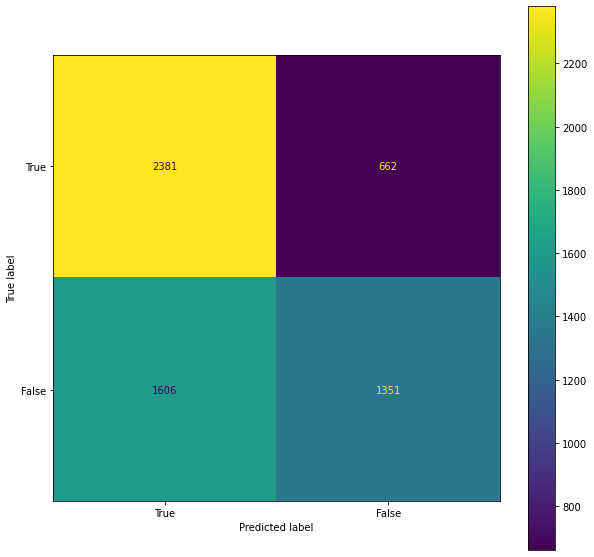

              precision    recall  f1-score   support

           0       0.63      0.84      0.72      6957
           1       0.76      0.52      0.62      7043

    accuracy                           0.68     14000
   macro avg       0.70      0.68      0.67     14000
weighted avg       0.70      0.68      0.67     14000

              precision    recall  f1-score   support

           0       0.60      0.78      0.68      3043
           1       0.67      0.46      0.54      2957

    accuracy                           0.62      6000
   macro avg       0.63      0.62      0.61      6000
weighted avg       0.63      0.62      0.61      6000



In [19]:
model_pipe(df_r)

In [20]:
from sklearn.model_selection import GridSearchCV
Gpipe = Pipeline([('count_vect',CountVectorizer(stop_words="english")),
                ('tfidf_transformer',TfidfTransformer()),
                ('nbClassifier',BernoulliNB())])


parameters = {
    'count_vect__binary': [True, False],
    'count_vect__ngram_range': [(1, 1), (1, 2)],
    'nbClassifier__alpha': (1, 0.1),
}

grid_search = GridSearchCV(Gpipe, parameters, cv=5)

In [ ]:
clf = grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

## **XG Boost Classifier**

In [ ]:
import xgboost as xgb

In [ ]:
def xgmodel_pipe(df):
    X_train, X_test, y_train, y_test = train_test_split(df["review_text"], df["is_spoiler"],
                                                        test_size=0.30, random_state=9)
    # pipline the process for text classification
    pipe = Pipeline([("count_vectorizer", CountVectorizer(stop_words = "english")),
                     ("tfidf_transformer", TfidfTransformer()),
                     ("xg_classifier", xgb.XGBClassifier())])

    # fit the model to the train data
    pipe.fit(X_train, y_train)

    # predict the train values
    train_pred = pipe.predict(X_train)

    # predict the test
    test_pred = pipe.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,test_pred)
    fig,ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=is_spoiler)
    disp.plot(ax=ax)
    plt.show()
    
     # Classification report
    print(classification_report(y_train, train_pred))
    print(classification_report(y_test, test_pred))

In [ ]:
xgmodel_pipe(df_r)

## Word2Vec and Transformer

In [ ]:
import spacy
from functools import reduce
import gensim
from gensim.models import Word2Vec
nlp = spacy.load('en_core_web_lg')

In [ ]:
reframed_data = d.merge(df_details, how='left', on='movie_id')
reframed_data.head()

In [ ]:
# train and test spilt for word embedding technique
x_train, x_test, Y_train, Y_test = train_test_split(reframed_data[["review_text","plot_summary"]],reframed_data["is_spoiler"],
                                                    test_size=0.30, random_state=9)

In [ ]:
from functools import reduce
def tn(sentence): # vocab to vector generation of textm
    return np.sum([nlp.vocab[w].vector for w in sentence.split()])

def transform1(row):
        s1 = tn(row.review_text)
        s2 = tn(row.plot_summary)
        return np.stack([s1,s2])
    
def transform(X):
        return np.concatenate(
            [transform1(row).reshape(1, -1) for row in X.itertuples()]
        )

def cosine_sim(arr1, arr2): 
    ### to predict the spoiler by comparing the review text with orginal plot summary
    return np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))


def transform2(row):
        s1 = tn(row.review_text)
        s2 = tn(row.plot_summary)
        return cosine_sim(s1,s2)
    
    
def similarity_predict(data, threshold):   
    simPred = []
    for row in data.itertuples():
        sim = transform2(row)
        if sim >=threshold:
            simPred.append(int(1))
        else:
            simPred.append(int(0))
    return simPred

In [ ]:
# By using the cosine similarity to identify which reviews having the spoiler
a = similarity_predict(x_train,0.9)
b = similarity_predict(x_test,0.9)

sim_train_pred = pd.DataFrame(a)
sim_test_pred  = pd.DataFrame(b)

print(classification_report(sim_train_pred,Y_train))
print(classification_report(sim_test_pred,Y_test))

## USing MLP Regressor in word embedding for the classification of spoilers

In [ ]:
# transform the trainng and development data
processed_train = transform(x_train)
processed_test  = transform(x_test)

In [ ]:
# multilayer perceptron clssifier 
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( max_iter=80,hidden_layer_sizes=(400,400,400)).fit(processed_train,Y_train) # y - gold_label of df_train

test_pred_processed = clf.predict(processed_test)
print(classification_report(test_pred_processed,Y_test)) 

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, test_pred_processed))

## **Bert Method**

In [ ]:
import random
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import seaborn as sns
import tqdm.notebook as tq
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
df_r

In [ ]:
token_lens = []
for txt in tq.tqdm(df_r.review_text):
    tokens = tokenizer.encode(txt, max_length=800)
    token_lens.append(len(tokens))
    

In [ ]:
sns.displot(token_lens)
plt.xlim([0, 850]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 60
BATCH_SIZE = 16

In [ ]:
class GPReviewDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
  

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review,
                                               add_special_tokens=True,max_length=self.max_len,
                                               return_token_type_ids=False,pad_to_max_length=True,
                                               return_attention_mask=True,return_tensors='pt',)
        return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review_text.to_numpy(),
        targets=df.is_spoiler.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    return DataLoader(ds,batch_size=batch_size,
                      num_workers=4)

In [ ]:
df_r

In [ ]:
df_train, df_test = train_test_split(
  df_r,
  test_size=0.2,
  random_state=9
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=9
)

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
train_data_loader

In [ ]:
data = next(iter(train_data_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SpoilerClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SpoilerClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask).to_tuple()
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
class_names = ['no_spoilers', 'has_spoilers']

In [ ]:
model = SpoilerClassifier(len(class_names))
model = model.to(device)

In [ ]:
#### input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,
                device,scheduler,n_examples):
    
        model = model.train()
        losses = []
        correct_predictions = 0
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
print(f'Train loss {train_loss} accuracy {train_acc}')
val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
print(f'Val   loss {val_loss} accuracy {val_acc}')
print()
history['train_acc'].append(train_acc)
history['train_loss'].append(train_loss)
history['val_acc'].append(val_acc)
history['val_loss'].append(val_loss)
if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

###################

In [ ]:
d.groupby('is_spoiler').describe()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(d['review_text'],d['is_spoiler'], stratify=d['is_spoiler'])

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")